In [5]:
import sys, os
sys.path.append('../')
sys.path.append('../scDART/')


import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import load_npz

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from umap import UMAP

import scDART.diffusion_dist as diff
import scDART.dataset as dataset
import scDART.model as model
import scDART.loss as loss
import scDART.train as train
import scDART.utils as utils
import scDART.post_align as palign
import scDART.benchmark as bmk
import scDART.TI as ti
import networkx as nx
import seaborn as sns


# Train model

In [6]:
def scDART_train(EMBED_CONFIG, reg_mtx, train_rna_loader, train_atac_loader, test_rna_loader, test_atac_loader, n_epochs = 1001, use_anchor = True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # calculate the distance
    for data in test_rna_loader:
        dist_rna = diff.diffu_distance(data["count"].numpy(), ts = [40, 50], 
        use_potential = False, dr = "pca", method = "exact", n_anchor = 300)

    for data in test_atac_loader:
        dist_atac = diff.diffu_distance(data["count"].numpy(), ts = [40, 50], 
        use_potential = False, dr = "lsi", method = "exact", n_anchor = 300)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)

    genact = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    decoder = model.Decoder(features = EMBED_CONFIG["proj_layers"][::-1], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    genact_t = model.gene_act_t(features = EMBED_CONFIG["gact_layers"][::-1], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": genact, "encoder": encoder, "decoder": decoder, "gene_act_t": genact_t}

    learning_rate = EMBED_CONFIG['learning_rate']
    opt_genact = torch.optim.Adam(genact.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_decoder = torch.optim.Adam(decoder.parameters(), lr = learning_rate)
    opt_genact_t = torch.optim.Adam(genact_t.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder, "decoder": opt_decoder, "gene_act_t": opt_genact_t}

    train.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                        data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = n_epochs, 
                        reg_mtx = reg_mtx, reg_d = 1, reg_g = 1, reg_mmd = 1, use_anchor = use_anchor, norm = "l1", 
                        mode = "kl")

    with torch.no_grad():
        for data in test_rna_loader:
            z_rna = model_dict["encoder"](data['count'].to(device)).cpu().detach()

        for data in test_atac_loader:
            z_atac = model_dict["encoder"](model_dict["gene_act"](data['count'].to(device))).cpu().detach()


    # post-maching
    z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

  
    return model_dict, z_rna, z_atac


In [11]:
data_name = "bifur1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rna_dataset = dataset.symsim2_rna(counts_dir = "../data/simulated/" + data_name + "/GxC1.txt", 
                            anno_dir = "../data/simulated/" + data_name + "/cell_label1.txt",        
                            anchor = None, libsize = 100)

atac_dataset = dataset.symsim2_atac(counts_dir = "../data/simulated/" + data_name + "/RxC2.txt", 
                            anno_dir = "../data/simulated/" + data_name + "/cell_label2.txt",
                            anchor = None)
 
coarse_reg = torch.FloatTensor(pd.read_csv("../data/simulated/" + data_name + "/region2gene.txt", 
                                            sep = "\t", header = None).values).to(device)


batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
libsize = rna_dataset.get_libsize()

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

EMBED_CONFIG = {
    'gact_layers': [atac_dataset.counts.shape[1], 512, 256, rna_dataset.counts.shape[1]], 
    'proj_layers': [rna_dataset.counts.shape[1], 128, 8], # number of nodes in each 
    'learning_rate': 5e-4
}

model_dict, z_rna, z_atac = scDART_train(EMBED_CONFIG = EMBED_CONFIG, reg_mtx = coarse_reg, 
                                                        train_rna_loader = train_rna_loader, 
                                                        train_atac_loader = train_atac_loader, 
                                                        test_rna_loader = test_rna_loader, 
                                                        test_atac_loader = test_atac_loader, 
                                                        n_epochs = 1201, use_anchor = False
                                                        )



running time(sec): 1.6028292179107666
running time(sec): 1.6055326461791992
running time(sec): 1.7545146942138672
running time(sec): 1.7975263595581055
epoch:  0
	 mmd loss: 0.113
	 ATAC dist loss: 0.293
	 RNA dist loss: 0.129
	 gene activity loss: 5667.453
	 anchor matching loss: 0.000
epoch:  10
	 mmd loss: 0.044
	 ATAC dist loss: 0.170
	 RNA dist loss: 0.039
	 gene activity loss: 230.726
	 anchor matching loss: 0.000
epoch:  20
	 mmd loss: 0.039
	 ATAC dist loss: 0.090
	 RNA dist loss: 0.032
	 gene activity loss: 41.446
	 anchor matching loss: 0.000
epoch:  30
	 mmd loss: 0.036
	 ATAC dist loss: 0.047
	 RNA dist loss: 0.030
	 gene activity loss: 28.668
	 anchor matching loss: 0.000
epoch:  40
	 mmd loss: 0.038
	 ATAC dist loss: 0.033
	 RNA dist loss: 0.025
	 gene activity loss: 24.211
	 anchor matching loss: 0.000
epoch:  50
	 mmd loss: 0.035
	 ATAC dist loss: 0.026
	 RNA dist loss: 0.022
	 gene activity loss: 21.257
	 anchor matching loss: 0.000
epoch:  60
	 mmd loss: 0.035
	 ATAC 

epoch:  600
	 mmd loss: 0.031
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.012
	 gene activity loss: 1.621
	 anchor matching loss: 0.000
epoch:  610
	 mmd loss: 0.033
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.012
	 gene activity loss: 1.554
	 anchor matching loss: 0.000
epoch:  620
	 mmd loss: 0.034
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.012
	 gene activity loss: 1.484
	 anchor matching loss: 0.000
epoch:  630
	 mmd loss: 0.034
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.011
	 gene activity loss: 1.419
	 anchor matching loss: 0.000
epoch:  640
	 mmd loss: 0.036
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.012
	 gene activity loss: 1.354
	 anchor matching loss: 0.000
epoch:  650
	 mmd loss: 0.034
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.011
	 gene activity loss: 1.293
	 anchor matching loss: 0.000
epoch:  660
	 mmd loss: 0.034
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.012
	 gene activity loss: 1.234
	 anchor matching loss: 0.000
epoch:  670
	 mmd loss: 0.039
	 ATAC dist loss: 0.011
	

# Plot results

None
None


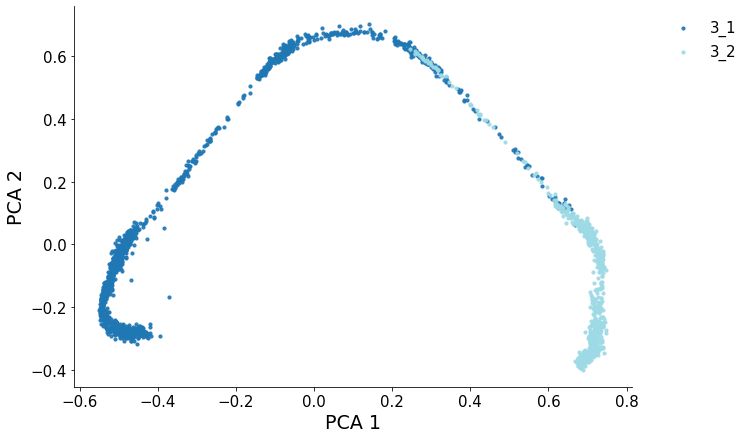

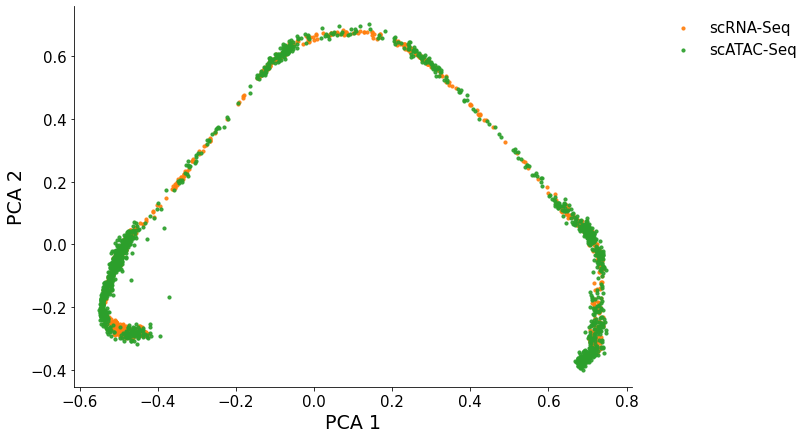

In [15]:
# visualize the latent embedding
pca_op = PCA(n_components = 2)
z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
z_rna_pca = z[:z_rna.shape[0],:]
z_atac_pca = z[z_rna.shape[0]:,:]

utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, 
                    anno2 = atac_dataset.cell_labels, mode = "joint",
                    save = None, 
                    figsize = (10,7), axis_label = "PCA")


utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality", save = None, figsize = (10,7), axis_label = "PCA")



running Leiden clustering
finished
None


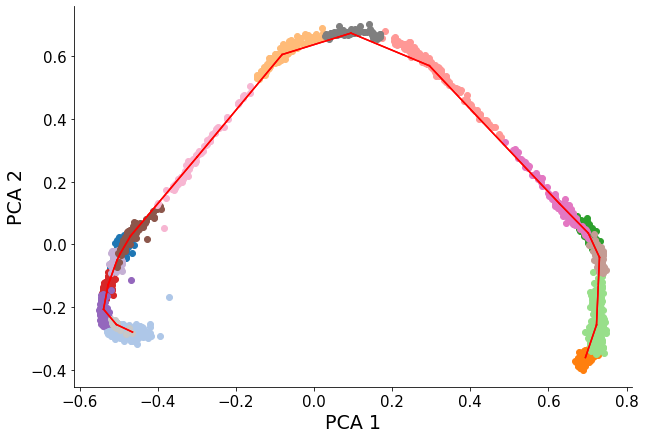

In [17]:
import scDART.TI as ti
dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)

# rna first
# give the root cell number
root_cell = 0
pt_infer = dpt_mtx[root_cell, :]
pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
pt_infer = pt_infer/np.max(pt_infer)

groups, mean_cluster, T = ti.backbone_inf(z_rna, z_atac, resolution = 0.5)

pca_op = PCA(n_components=2)
ae_coord = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
mean_cluster = pca_op.transform(np.array(mean_cluster))

ae_rna = ae_coord[:z_rna.shape[0],:]
ae_atac = ae_coord[z_rna.shape[0]:,:]

utils.plot_backbone(ae_rna, ae_atac, mode = "joint", mean_cluster = mean_cluster, groups = groups, T = T, 
              figsize=(10,7), save = None, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, axis_label = "PCA")



None


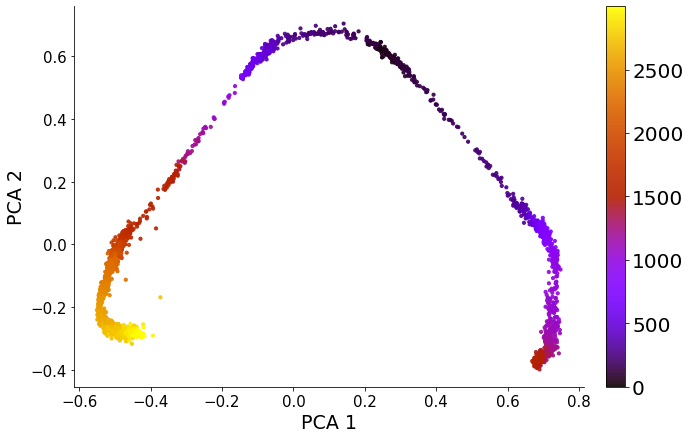

In [20]:
utils.plot_latent_pt(ae_rna, ae_atac, pt1 = pt_infer[:ae_rna.shape[0]], pt2 = pt_infer[ae_rna.shape[0]:], 
                     mode = "joint", save = None, figsize = (10,7), axis_label = "PCA")